In [1]:
!pip install langchain-cohere

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_cohere import CohereEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_google_genai import ChatGoogleGenerativeAI
# Set embeddings
embd = CohereEmbeddings(model="embed-v4.0")

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=512/2,
    chunk_overlap=0
)

doc_splits = text_splitter.split_documents(docs_list)

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    embedding=embd
)

retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [29]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_cohere import ChatCohere
from pydantic import BaseModel, Field

# Data Model
class web_search(BaseModel):
    """
    The internet. Use web_search for questions that are related to anything else than agents, prompt engineering, and adversarial attacks.
    """

    query: str = Field(description="The query to use when searching the internet.")


class vectorstore(BaseModel):
    """
    A vectorstore containing documents related to agents, prompt engineering, and adversarial attacks. Use the vectorstore for questions on these topics.
    """

    query: str = Field(description="The query to use when searching the vectorstore.")

preamble = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions related to these topics. Otherwise, use web-search"""

llm = ChatCohere(model="command-r", temperature=0)
structured_llm_router = llm.bind_tools(
    tools=[web_search, vectorstore], preamble=preamble
)

# Prompt
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
response = question_router.invoke(
    {"question": "Who will the Bears draft first in the NFL draft?"}
)
response = question_router.invoke({"question": "Who wil the Bears draft first in the NFL draft"})
print(response.additional_kwargs["tool_calls"])

response = question_router.invoke({"question": "Hi how are you"})


[{'id': 'web_search_bgzf7ff1sm88', 'type': 'function', 'function': {'name': 'web_search', 'arguments': '{"query":"who will the bears pick first in the NFL draft"}'}}]


In [14]:
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")
# Prompt
preamble = """You are a grader assessing relevance of a retrieved document to a user question. \n
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# LLM with function call
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", preamble),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "What is agents"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
response = retrieval_grader.invoke({"question": question, "document": doc_txt})
print(response)

binary_score='yes'


In [ ]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
import langchain
from langchain_core.messages import HumanMessage
# Preamble
preamble = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise."""

# LLM
llm = ChatCohere(model_name="command-r", temperature=0).bind(preamble=preamble)

prompt = lambda x: ChatPromptTemplate.from_messages(
    [
        HumanMessage(
            f"Question: {x['question']} \nAnswer:",
            additional_kwargs={"documents":x['documents']},
        )
    ]
)
rag_chain = prompt | llm | StrOutputParser()

generation = rag_chain.invoke({'question': question, "documents":docs})
print(generation)


In [59]:
type(docs[0])

langchain_core.documents.base.Document

In [50]:
# LLM Fallback
preamble = """You are an assistant for question-answering tasks. Answer the question based upon your knowledge. Use three sentences maximum and keep the answer concise."""

llm = ChatCohere(model_name='command-r', temperature=0).bind(preamble=preamble)

prompt = lambda x: ChatPromptTemplate.from_messages(
    [
        HumanMessage(
            f"Question: {x['question']} \nAnswer"
        )
    ]
)

llm_chain = prompt | llm | StrOutputParser()

question = "Hi how are you"
generation = llm_chain.invoke({"question":question})
print(generation)

Hello! I'm an AI, so I don't have feelings, but I'm functioning well and ready to assist you. How can I help you today?


In [51]:
### HHalucination Grader

class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer"""

    binary_score: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

preamble = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

llm = ChatCohere(model='command-r', temperature=0)

structured_llm_grader = llm.with_structured_output(GradeHallucinations)

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", preamble),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation {generation}")
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({'documents':docs, "generation":generation})

GradeHallucinations(binary_score='yes')

In [52]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# Preamble
preamble = """You are a grader assessing whether an answer addresses / resolves a question \n
Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

# LLM with function call
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", preamble),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [53]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()

In [69]:

from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM generation
        docuemnts: list of documents
    """
    question: str
    generation: str
    documents: List[str]

from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents
    Args:
        state: the current graph state
    Returns:
        state: new key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state['question']
    documents = retriever.invoke(question)
    return {"documents":documents, "question":question}

def llm_fallback(state):
    """Generate answer using the LLM w/o vectorstore
    Args:
        state: the current graph state
    Returns:
        state: new key added to state, generation, that contains LLM generation"""
    print("---LLM FALBACK---")
    question = state['question']
    generation = llm_chain.invoke({"question":question})
    return {"question": question, "generation":generation}

def generate(state):
    """
    Generate answer using the vectorstore
    Args:
        state: the current graph state
    Returns:
        state: New key added to state, documents, that contains retrieved documents
    """
    print("---GENERATION---")
    question = state['question']
    print(question)
    documents = state['documents']
    
    if not isinstance(documents, list):
        documents = [documents]
    print(len(documents))
    generation = rag_chain.invoke({'documents': documents, "question":question})
    return {"documents": documents, "question":question, "generation":generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    Args:
        state: the current graph state
    Returns:
        state: Updates documents key with only filtered relevant documents"""
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state['question']
    documents = state['documents']
    
    filtered_documents = []
    for doc in documents:
        score = retrieval_grader.invoke({'question':question, "document":doc.page_content})
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_documents.append(doc)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents":filtered_documents, "question":question}

def web_search(state):
    """
    Web search base on the re-phrased question
    Args:
        state: The current graph state
    Returns: 
        state: Updates documents key with appended web results"""
    question = state['question']
    docs = web_search_tool.invoke({'query':question})
    web_results = "\n".join(d['content'] for d in docs)
    web_results = Document(page_content=web_results)
    return {"documents": web_results, "question":question}


def route_question(state):
    """
    Route question to web search or RAG
    
    Args: 
        state: The current graph state
    Returns:
        str: Next node to call"""
    print("---ROUTE QUESTION---")
    question = state['question']
    source = question_router.invoke({'question':question})
    if "tool_calls" not in source.additional_kwargs:
        print("---ROUTE QUESTION TO LLM---")
        return "llm_fallback"
    if len(source.additional_kwargs['tool_calls']) == 0:
        raise "Router could not decide source"
    
    datasource = source.additional_kwargs['tool_calls'][0]['function']['name']
    if datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif datasource == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return 'vectorstore'
    else:
        print("---ROUTE QUESTION TO LLM---")
        return "llm_fallback"
    
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question
    Args: 
        state: The current graph state
    Returns:
        str: Binary decision for next node to call"""
    print("---ASSESS GRADED DOCUMENTS---")
    question = state['question']
    filtered_documents = state['documents']
    if not filtered_documents:
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, WEB SEARCH---")
        return 'web_search'
    else:
        print("---DECISION: GENERATE")
        return "generate"
    
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args: 
        state: The current graph state
    Returns:
        str: Decision for next node to call
    """
    print('---CHECK HALLUCINATIONS---')
    generation = state['generation']
    documents=state['documents']
    question=state['question']
    score = hallucination_grader.invoke({'documents':documents, "generation":generation})
    grade = score.binary_score

    if grade=="yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({'question':question, "generation":generation})
        grade = score.binary_score
        if grade == 'yes':
            print("---DECISION: GENERATION ADDRESSES QUESTION")
            return 'useful'
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESSES QUESTION")
            return 'not useful'
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"


In [70]:
import pprint
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

workflow.add_node("web_search", web_search)
workflow.add_node('retrieve', retrieve)
workflow.add_node('grade_documents', grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("llm_fallback", llm_fallback)

workflow.set_conditional_entry_point(
    route_question,
    {
        'web_search':"web_search",
        "vectorstore": "retrieve",
        "llm_fallback":"llm_fallback",
    }
)
workflow.add_edge("web_search", "generate")
workflow.add_edge('retrieve', "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "web_search":'web_search',
        "generate": 'generate'
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        'not supported': "generate",
        "not useful": 'web_search',
        'useful':END
    }
)
workflow.add_edge('llm_fallback', END)
app = workflow.compile()

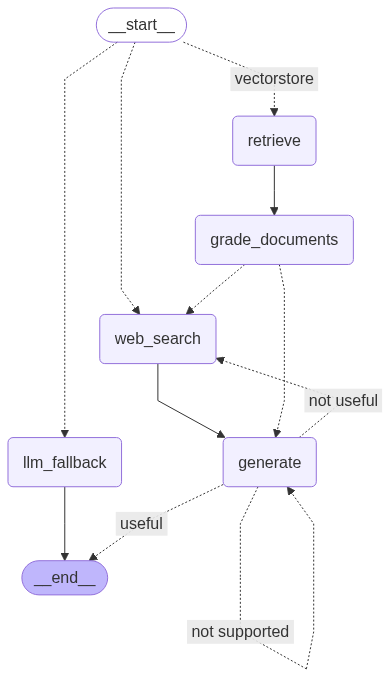

In [71]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [74]:
inputs = {"question": "What players are the Bears expected to draft first in the 2024 NFL draft?"}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Node: '{key}': ")

    pprint.pprint("\n---\n")

pprint.pprint(value['generation'])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
"Node: 'web_search': "
'\n---\n'
---GENERATION---
What players are the Bears expected to draft first in the 2024 NFL draft?
1
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION
"Node: 'generate': "
'\n---\n'
('The Chicago Bears are expected to pick USC quarterback Caleb Williams at No. '
 '1 in the 2024 NFL Draft. The Williams pick has been assumed for months, but '
 'Bears general manager Ryan Poles played coy in his pre-draft news '
 "conference. The Bears acquired the pick from Carolina in last year's trade "
 'for the No. 1 overall pick in the 2023 draft.')


In [67]:
inputs = {"question": "What are the types of agent memory?"}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Node: '{key}': ")

    pprint.pprint("\n---\n")

pprint.pprint(value['generation'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node: 'retrieve': "
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE
"Node: 'grade_documents': "
'\n---\n'
---GENERATION---
What are the types of agent memory?
4
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION
"Node: 'generate': "
'\n---\n'
('The types of agent memory are sensory memory, short-term memory, and '
 'long-term memory.')


In [75]:
inputs = {"question": "Hello, how are you?"}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Node: '{key}': ")

    pprint.pprint("\n---\n")

pprint.pprint(value['generation'])

---ROUTE QUESTION---
---ROUTE QUESTION TO LLM---
---LLM FALBACK---
"Node: 'llm_fallback': "
'\n---\n'
("Hello! As an AI, I don't have feelings, but I'm functioning well and ready "
 'to assist you. How can I help you today?')
